In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score, average_precision_score, confusion_matrix
import matplotlib.pylab as plt

In [2]:
df = pd.read_csv('ethereum_df1.csv')

In [3]:
df.head()

,flag,sent_tnx,total_transactions_(including_tnx_to_create_contract,min_val_sent,received_tnx,avg_val_sent,avg_min_between_received_tnx,avg_val_received,min_value_received,unique_received_from_addresses,time_diff_between_first_and_last_(mins)
0,0,721,810,0.00,89,1.200681,1093.71,6.589513,0.000000,40,704785.63
1,0,94,102,0.00,8,0.032844,2958.44,0.385685,0.000000,5,1218216.73
2,0,2,12,0.05,10,1.794308,2434.02,0.358906,0.113119,10,516729.30
3,0,25,34,0.00,9,70.001834,15785.09,99.488840,0.000000,7,397555.90
4,0,4598,4619,0.00,20,0.022688,10707.77,2.671095,0.000000,7,382472.42


In [4]:
df.shape

(9823, 11)

In [5]:
X = df.iloc[:,1:12] # All features column
y = df.iloc[:,0:1] # flag columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((7858, 10), (1965, 10), (7858, 1), (1965, 1))

In [6]:
# LGBM function to read the data

data_train = lgb.Dataset(X_train, label = y_train)
data_test = lgb.Dataset(X_test, label = y_test)

In [7]:
# Parameters specification for LGBM

params = {'objective':'binary', # binary classification, default is regression
          'metric':'auc',
          'is_unbalance':'true', # data is imbalanced
          'feature_fraction':0.5,
          'force_col_wise':'true', # number of bin is large, reduce memory cost + advise from warning 
          'verbosity': 0
             }

In [8]:
early_stop = lgb.early_stopping(15) # early_stopping_round deprecated, warning to use callback instead.

model = lgb.train(params,
                  data_train,
                  num_boost_round = 1000,
                  valid_sets = data_test,
                  callbacks=[early_stop])

model.save_model('model.txt', num_iteration=model.best_iteration)

Training until validation scores don't improve for 15 rounds
Early stopping, best iteration is:
[92]	valid_0's auc: 0.982091


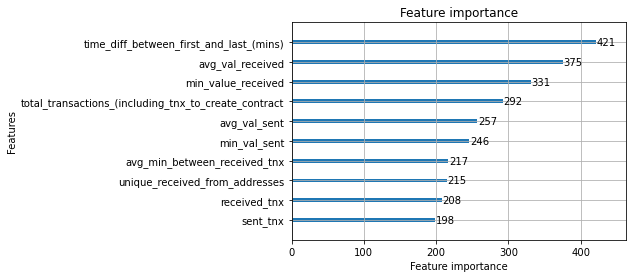

In [9]:
lgb.plot_importance(model)

In [10]:
y_pred = model.predict(X_test, num_iteration=model.best_iteration)

In [11]:
roc_auc_score(y_test, y_pred)

0.9820913029223683

In [12]:
average_precision_score(y_test, y_pred)

0.9476378386442129

In [13]:
y_pred 
# lgbm does not return 0 & 1, it returns probablility.
# even if objective is set at binary and using predict instead of predict_proba
# source stackoverflow + lgbm documentation
# https://lightgbm.readthedocs.io/en/latest/R/reference/predict.lgb.Booster.html

array([6.29484281e-03, 9.99169617e-01, 9.87093874e-04, ...,
       9.99169617e-01, 1.63946294e-02, 2.54769138e-02])

In [14]:
# Threshold optimization is for another day, how much false positive can we accept?

y_pred_convert = np.where(y_pred>0.7, 1,0)

In [15]:
y_pred_convert

array([0, 1, 0, ..., 1, 0, 0])

In [16]:
f1_score(y_test,y_pred_convert)

0.8631840796019901

In [17]:
confusion_matrix(y_test, y_pred_convert)

array([[1508,   55],
       [  55,  347]], dtype=int64)